In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False

In [ ]:
if IN_COLAB:
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
    !python rapidsai-csp-utils/colab/pip-install.py
    pass

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pd.set_option("display.width", 10000)

TESTING = True
TESTING_SIZE = 0.001
BENCMARK_ITER_N = 1
random_state = 245

benchmark_results = pd.DataFrame(
    columns=[
        "Model",
        "Dataset",
        "Info",
        "Data size",
        "Accuracy",
        "Precision",
        "Recall",
        "F1",
        "Time per data per iter",
    ]
)


def benchmarkAndUpdateResult(X_test, y_test, model, model_name, dataset_name, info=""):
    """
    Benchmark the model and update the results dataframe

    Parameters
    ----------
    X_test : The test data
    y_test : The actual test labels
    model : The model to be benchmarked, must have the predict method
    model_name : The name of the model
    dataset_name : The name of the dataset
    info : Additional information about the model
    """
    global benchmark_results
    data_size = np.shape(X_test)[0]
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    iter_n = BENCMARK_ITER_N
    start = time.time()
    for _ in range(iter_n):  # benchmark
        for j in range(data_size):  # simulating real time data
            model.predict(X_test[j : j + 1])
    end = time.time()
    time_per_data_per_iter = (end - start) / data_size / iter_n
    benchmark_results.loc[len(benchmark_results)] = [
        model_name,
        dataset_name,
        info,
        data_size,
        accuracy,
        precision,
        recall,
        f1,
        time_per_data_per_iter,
    ]
    print(f"Model: {model_name}")
    print(f"Data size: {data_size}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"Time per data per iter: {time_per_data_per_iter}")

In [2]:
# sample binary classification, replace wiht the actual code for the project
if IN_COLAB:
    from cuml.svm import SVC
    import cudf
    %load_ext cudf.pandas
else:
    from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [3]:
if IN_COLAB:
    prepend_path = "/content/drive/MyDrive/Syncable/sjsu/data-245/DATA 245 Project Files/data"
else:
    prepend_path = "./data"
known_attacks_path = f"{prepend_path}/probe_known_attacks_small.csv"
similar_attacks_path = f"{prepend_path}/probe_similar_attacks_small.csv"
new_attacks_path = f"{prepend_path}/probe_new_attacks_small.csv"

In [4]:
df = pd.read_csv(known_attacks_path, low_memory=False)

In [5]:
if TESTING:
    df = df.sample(frac=TESTING_SIZE, random_state=random_state)
    df.reset_index(drop=True, inplace=True)
df.shape

(85, 51)

In [6]:
df.columns

Index(['ip_type', 'ip_len', 'ip_id', 'ip_offset', 'ip_RF', 'ip_DF', 'ip_MF', 'ip_proto', 'ip_checksum', 'udp_sport', 'udp_dport', 'udp_len', 'udp_chk', 'icmp_type', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_frst', 'tcp_fpush', 'tcp_fack', 'tcp_furg', 'fr_length', 'conn_status', 'count_fr_src_dst', 'count_fr_dst_src', 'count_serv_src_dst', 'count_serv_dst_src', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_pushed_dst_src', 'num_syn_fin_src_dst', 'num_syn_fin_dst_src', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_ack_dst_src', 'num_syn_src_dst', 'num_syn_dst_src', 'num_rst_src_dst', 'num_rst_dst_src', 'first_packet', 'first_serv_packet', 'class'], dtype='object')

In [7]:
df.head()

,ip_type,ip_len,ip_id,ip_offset,ip_RF,ip_DF,ip_MF,ip_proto,ip_checksum,udp_sport,...,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
0,0,90,0,0,0,1,0,17,47118,46978,...,1,160,312,1,1,0,0,0,0,normal
1,0,74,0,0,0,1,0,17,47134,39806,...,2,189,300,2,2,0,0,0,0,normal
2,0,52,60702,0,0,1,0,6,52022,0,...,1,257,389,2,2,0,0,0,0,normal
3,0,40,3309,0,0,0,0,6,62806,0,...,0,0,4,0,0,0,4,0,0,attack
4,0,552,32493,0,0,0,0,6,30593,0,...,2,280,494,3,3,0,0,0,0,normal


In [8]:
df.describe(include="all")

,ip_type,ip_len,ip_id,ip_offset,ip_RF,ip_DF,ip_MF,ip_proto,ip_checksum,udp_sport,...,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
count,85.000000,85.000000,85.000000,85.0,85.0,85.000000,85.0,85.000000,85.000000,85.000000,...,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.0,85.000000,85
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
mean,0.470588,108.388235,31657.552941,0.0,0.0,0.364706,0.0,7.752941,33899.529412,7275.917647,...,0.470588,101.788235,232.388235,43.117647,21.458824,0.858824,134.223529,0.0,0.058824,NaN
std,4.338609,206.957903,18743.854364,0.0,0.0,0.484204,0.0,4.165922,16974.614660,18270.583999,...,0.795646,178.733380,279.443243,151.586877,184.463092,3.552842,243.131621,0.0,0.236691,NaN
min,0.000000,28.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,2546.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN
25%,0.000000,40.000000,17275.000000,0.0,0.0,0.000000,0.0,6.000000,20146.000000,0.000000,...,0.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN
50%,0.000000,44.000000,32054.000000,0.0,0.0,0.000000,0.0,6.000000,32698.000000,0.000000,...,0.000000,10.000000,150.000000,1.000000,0.000000,0.000000,2.000000,0.0,0.000000,NaN
75%,0.000000,60.000000,46056.000000,0.0,0.0,1.000000,0.0,6.000000,47117.000000,0.000000,...,1.000000,156.000000,395.000000,3.000000,2.000000,0.000000,202.000000,0.0,0.000000,NaN


It seems as though ip_RF, ip_MF, and ip_offset do not contain any valuable information. They can be removed

In [9]:
df = df.drop(columns=["ip_RF", "ip_MF", "ip_offset"])

In [10]:
df.columns

Index(['ip_type', 'ip_len', 'ip_id', 'ip_DF', 'ip_proto', 'ip_checksum', 'udp_sport', 'udp_dport', 'udp_len', 'udp_chk', 'icmp_type', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_frst', 'tcp_fpush', 'tcp_fack', 'tcp_furg', 'fr_length', 'conn_status', 'count_fr_src_dst', 'count_fr_dst_src', 'count_serv_src_dst', 'count_serv_dst_src', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_pushed_dst_src', 'num_syn_fin_src_dst', 'num_syn_fin_dst_src', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_ack_dst_src', 'num_syn_src_dst', 'num_syn_dst_src', 'num_rst_src_dst', 'num_rst_dst_src', 'first_packet', 'first_serv_packet', 'class'], dtype='object')

In [11]:
print(df["class"].value_counts())
print(df["class"].value_counts(normalize=True) * 100)

class
normal    47
attack    38
Name: count, dtype: int64
class
normal    55.294118
attack    44.705882
Name: proportion, dtype: float64


In [12]:
df.dtypes

ip_type                    int64
ip_len                     int64
ip_id                      int64
ip_DF                      int64
ip_proto                   int64
ip_checksum                int64
udp_sport                  int64
udp_dport                  int64
udp_len                    int64
udp_chk                    int64
icmp_type                  int64
icmp_code                  int64
icmp_chk                   int64
tcp_sport                  int64
tcp_dport                  int64
tcp_seq                    int64
tcp_ack                    int64
tcp_ffyn                   int64
tcp_fsyn                   int64
tcp_frst                   int64
tcp_fpush                  int64
tcp_fack                   int64
tcp_furg                   int64
fr_length                  int64
conn_status                int64
count_fr_src_dst           int64
count_fr_dst_src           int64
count_serv_src_dst         int64
count_serv_dst_src         int64
num_bytes_src_dst          int64
num_bytes_

In [13]:
df["ip_type"].value_counts()

ip_type
0     84
40     1
Name: count, dtype: int64

In [14]:
df["class"] = df["class"].replace({"normal": 0, "attack": 1})

In [ ]:
df = df.astype(float)

In [15]:
corr = df.corr()

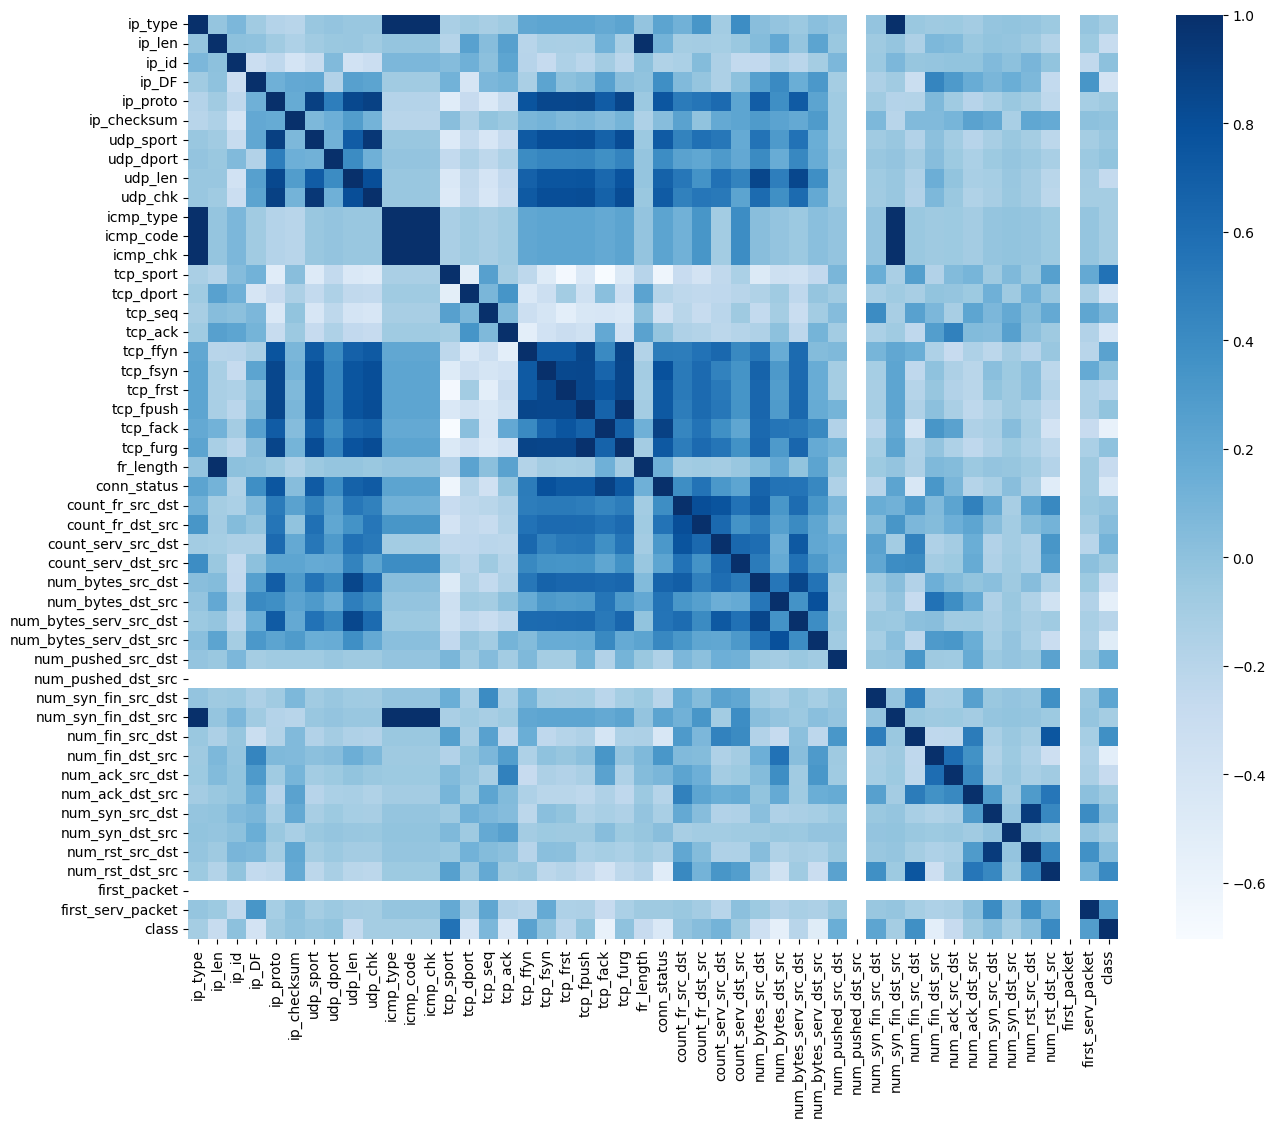

In [16]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap="Blues")
plt.show()

In [17]:
corr["class"].sort_values(ascending=False)

class                     1.000000
tcp_sport                 0.561654
num_rst_dst_src           0.412605
num_fin_src_dst           0.373727
first_serv_packet         0.278034
tcp_ffyn                  0.238745
num_syn_fin_src_dst       0.215573
num_pushed_src_dst        0.151350
count_serv_src_dst        0.114928
tcp_seq                   0.078503
num_syn_src_dst           0.031488
count_fr_dst_src          0.031201
num_rst_src_dst           0.029242
ip_id                     0.008978
tcp_fsyn                  0.000359
tcp_furg                 -0.002882
ip_checksum              -0.010512
udp_dport                -0.013002
tcp_fpush                -0.016549
count_fr_src_dst         -0.020264
udp_sport                -0.039822
count_serv_dst_src       -0.064564
ip_proto                 -0.066346
num_ack_dst_src          -0.070508
icmp_chk                 -0.098108
icmp_type                -0.098108
icmp_code                -0.098108
num_syn_fin_dst_src      -0.098108
ip_type             

The target feature does not seem to have very strong correlations with any particular feature.

In [18]:
# remove all features with an absolute correlation of less than 0.1
cols_corr_gt1 = corr["class"][abs(corr["class"]) > 0.1].index

In [19]:
print(cols_corr_gt1)
print(len(cols_corr_gt1))

Index(['ip_len', 'ip_DF', 'udp_len', 'udp_chk', 'tcp_sport', 'tcp_dport', 'tcp_ack', 'tcp_ffyn', 'tcp_frst', 'tcp_fack', 'fr_length', 'conn_status', 'count_serv_src_dst', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_syn_fin_src_dst', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_syn_dst_src', 'num_rst_dst_src', 'first_serv_packet', 'class'], dtype='object')
26


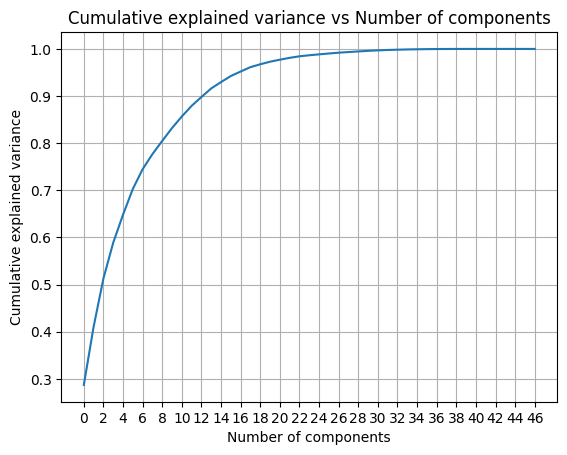

In [20]:
X = df.drop(columns=["class"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=len(df.columns) - 1)
X_pca = pca.fit_transform(X_scaled)

pca_cumsum = pca.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance vs Number of components")
plt.grid()
plt.xticks(range(0, len(df.columns) - 1, 2))
plt.show()

- at n=21, we have 85% of the variance explained
- at n=24, we have 90% of the variance explained
- at n=27, we have 95% of the variance explained

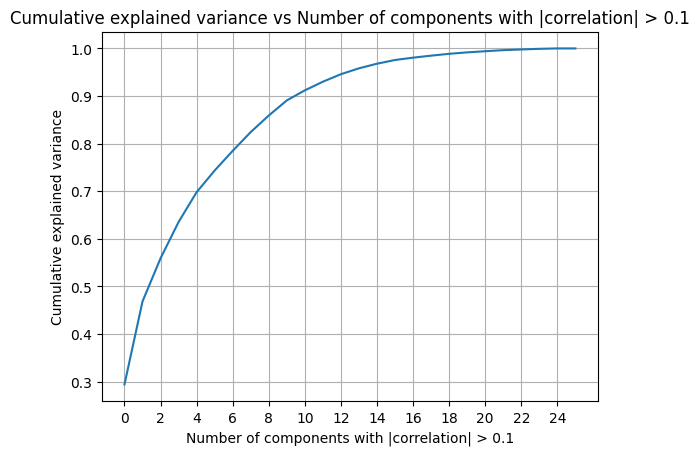

In [21]:
X_gt1 = df[cols_corr_gt1]

scaler_gt1 = StandardScaler()
X_gt1_scaled = scaler_gt1.fit_transform(X_gt1)

pca = PCA(n_components=len(cols_corr_gt1))
X_gt1_pca = pca.fit_transform(X_gt1_scaled)

pca_cumsum = pca.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum)
plt.xlabel("Number of components with |correlation| > 0.1")
plt.ylabel("Cumulative explained variance")
plt.title(
    "Cumulative explained variance vs Number of components with |correlation| > 0.1"
)
plt.grid()
plt.xticks(range(0, len(cols_corr_gt1), 2))
plt.show()

- at n=10 of the selected features, we have 95% of the variance explained

In [22]:
df_corr_gt1 = pd.DataFrame(df[cols_corr_gt1])
df_corr_gt1["class"] = df["class"]
df_corr_gt1.head()

,ip_len,ip_DF,udp_len,udp_chk,tcp_sport,tcp_dport,tcp_ack,tcp_ffyn,tcp_frst,tcp_fack,...,num_bytes_serv_dst_src,num_pushed_src_dst,num_syn_fin_src_dst,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_syn_dst_src,num_rst_dst_src,first_serv_packet,class
0,90,1,70,36224,0,0,0,2,2,2,...,53498,1,0,1,1,160,1,0,0,0
1,74,1,54,40008,0,0,0,2,2,2,...,9892,2,0,2,2,189,2,0,0,0
2,52,1,0,0,38686,80,229426048,0,0,1,...,102911,2,0,16,1,257,2,0,0,0
3,40,0,0,0,43694,38292,0,1,0,0,...,0,0,0,5,0,0,0,4,0,1
4,552,0,0,0,80,46765,2394833563,0,0,1,...,65535,9,0,2,2,280,3,0,0,0


In [23]:
df_corr_gt1 = df_corr_gt1.to_numpy()

In [ ]:
X_corr_gt1_train, X_corr_gt1_test, y_corr_gt1_train, y_corr_gt1_test = train_test_split(
    df_corr_gt1[:, :-1],
    df_corr_gt1[:, -1],
    test_size=0.2,
    random_state=random_state,
)

In [24]:
model_params = {
        "C": np.logspace(-3, 4, 8),
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
        }
model_params

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'gamma': ['scale', 'auto']}

In [25]:
verbose = 0
cv = 3
n_jobs = -1

In [ ]:
model_corr_gt1 = GridSearchCV(SVC(), model_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
model_corr_gt1.fit(X_corr_gt1_train, y_corr_gt1_train)

In [ ]:
model_corr_gt1.best_params_

In [ ]:
benchmarkAndUpdateResult(
    X_corr_gt1_test,
    y_corr_gt1_test,
    model_corr_gt1,
    f"SVM {model_corr_gt1.best_params_}",
    "Known attacks",
    "|correlation| > 0.1 features unscaled",
)

In [ ]:
df_corr_gt1_scaled = df_corr_gt1[:, :-1]
df_corr_gt1_scaler = StandardScaler()
df_corr_gt1_scaled = df_corr_gt1_scaler.fit_transform(df_corr_gt1_scaled)
df_corr_gt1_scaled = pd.DataFrame(
    df_corr_gt1_scaled, columns=cols_corr_gt1
)
df_corr_gt1_scaled["class"] = df["class"]
df_corr_gt1_scaled.head()

In [ ]:
df_corr_gt1_scaled = df_corr_gt1_scaled.to_numpy()

In [ ]:
(
    X_corr_gt1_scaled_train,
    X_corr_gt1_scaled_test,
    y_corr_gt1_scaled_train,
    y_corr_gt1_scaled_test,
) = train_test_split(
    df_corr_gt1_scaled[:, :-1],
    df_corr_gt1_scaled[:, -1],
    test_size=0.2,
    random_state=random_state,
)

In [ ]:
model_corr_gt1_scaled = GridSearchCV(SVC(), model_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
model_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

In [ ]:
model_corr_gt1_scaled.best_params_

In [ ]:
benchmarkAndUpdateResult(
    X_corr_gt1_scaled_test,
    y_corr_gt1_scaled_test,
    model_corr_gt1_scaled,
    f"SVM {model_corr_gt1_scaled.best_params_}",
    "Known attacks",
    "|correlation| > 0.1 features scaled",
)

In [ ]:
df_full = pd.DataFrame(df.drop(columns=["class"]))
df_full["class"] = df["class"]
df_full.head()

In [ ]:
df_full = df_full.to_numpy()

In [ ]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    df_full[:, :-1],
    df_full[:, -1],
    test_size=0.2,
    random_state=random_state,
)

In [ ]:
model_full = GridSearchCV(SVC(), model_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
model_full.fit(X_full_train, y_full_train)

In [ ]:
model_full.best_params_

In [ ]:
benchmarkAndUpdateResult(
    X_full_test,
    y_full_test,
    model_full,
    f"SVM {model_full.best_params_}",
    "Known attacks",
    "All features unscaled",
)

In [ ]:
df_full_scaled = df.drop(columns=["class"])
df_full_scaler = StandardScaler()
df_full_scaled = df_full_scaler.fit_transform(df_full_scaled)
df_full_scaled = pd.DataFrame(df_full_scaled, columns=df.drop(columns="class").columns)
df_full_scaled["class"] = df["class"]
df_full_scaled.head()

In [ ]:
df_full_scaled = df_full_scaled.to_numpy()

In [ ]:
X_full_scaled_train, X_full_scaled_test, y_full_scaled_train, y_full_scaled_test = (
    train_test_split(
        df_full_scaled[:, :-1],
        df_full_scaled[:, -1],
        test_size=0.2,
        random_state=random_state,
    )
)

In [ ]:
model_full_scaled = GridSearchCV(SVC(), model_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
model_full_scaled.fit(X_full_scaled_train, y_full_scaled_train)

In [ ]:
model_full_scaled.best_params_

In [ ]:
benchmarkAndUpdateResult(
    X_full_scaled_test,
    y_full_scaled_test,
    model_full_scaled,
    f"SVM {model_full_scaled.best_params_}",
    "Known attacks",
    "All features scaled",
)

In [ ]:
df_full_pca_95 = pd.DataFrame(X_pca[:, :27])
df_full_pca_95["class"] = df["class"]
df_full_pca_95.head()

In [ ]:
df_full_pca_95 = df_full_pca_95.to_numpy()

In [ ]:
X_full_pca_train, X_full_pca_test, y_full_pca_train, y_full_pca_test = train_test_split(
    df_full_pca_95[:, :-1],
    df_full_pca_95[:, -1],
    test_size=0.2,
    random_state=random_state,
)

In [ ]:
model_full_pca = GridSearchCV(SVC(), model_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
model_full_pca.fit(X_full_pca_train, y_full_pca_train)

In [ ]:
model_full_pca.best_params_

In [ ]:
benchmarkAndUpdateResult(
    X_full_pca_test,
    y_full_pca_test,
    model_full_pca,
    f"SVM {model_full_pca.best_params_}",
    "Known attacks",
    "PCA 95% on all features",
)

In [ ]:
df_corr_gt1_pca_95 = pd.DataFrame(X_gt1_pca[:, :10])
df_corr_gt1_pca_95["class"] = df["class"]
df_corr_gt1_pca_95.head()

In [ ]:
df_corr_gt1_pca_95 = df_corr_gt1_pca_95.to_numpy()

In [ ]:
X_corr_gt1_pca_train, X_corr_gt1_pca_test, y_corr_gt1_pca_train, y_corr_gt1_pca_test = (
    train_test_split(
        df_corr_gt1_pca_95[:, :-1],
        df_corr_gt1_pca_95[:, -1],
        test_size=0.2,
        random_state=random_state,
    )
)

In [ ]:
model_corr_gt1_pca = GridSearchCV(SVC(), model_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
model_corr_gt1_pca.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

In [ ]:
model_corr_gt1_pca.best_params_

In [ ]:
benchmarkAndUpdateResult(
    X_corr_gt1_pca_test,
    y_corr_gt1_pca_test,
    model_corr_gt1_pca,
    f"SVM {model_corr_gt1_pca.best_params_}",
    "Known attacks",
    "PCA 95% on features with |correlation| > 0.1",
)

In [ ]:
benchmark_results

- Best model in terms of accuracy and time: SVM with features with |correlation| > 0.1 and scaled
- Testing this model on the similar attacks dataset

In [ ]:
df_similar_attacks = pd.read_csv(similar_attacks_path, low_memory=False)

In [ ]:
df_similar_attacks = df_similar_attacks.drop(columns=["ip_RF", "ip_MF", "ip_offset"])
df_similar_attacks["class"] = df_similar_attacks["class"].replace(
    {"normal": 0, "attack": 1}
)
df_similar_attacks = pd.DataFrame(df_similar_attacks[cols_corr_gt1])
df_similar_attacks_scaled = df_corr_gt1_scaler.transform(
    df_similar_attacks.drop(columns="class")
)
df_similar_attacks_scaled = pd.DataFrame(
    df_similar_attacks_scaled, columns=df_similar_attacks.drop(columns="class").columns
)
df_similar_attacks_scaled["class"] = df_similar_attacks["class"]
df_similar_attacks_scaled.head()

In [ ]:
X_similar_attacks = df_similar_attacks_scaled.drop(columns=["class"]).to_numpy()
y_similar_attacks = df_similar_attacks_scaled["class"].to_numpy()

In [ ]:
benchmarkAndUpdateResult(
    X_similar_attacks,
    y_similar_attacks,
    model_corr_gt1_scaled,
    f"SVM {model_corr_gt1_scaled.best_params_}",
    "Similar attacks",
    "|correlation| > 0.1 features scaled",
)

In [ ]:
benchmark_results

In [ ]:
df_new_attacks = pd.read_csv(new_attacks_path, low_memory=False)

In [ ]:
df_new_attacks = df_new_attacks.drop(columns=["ip_RF", "ip_MF", "ip_offset"])
df_new_attacks["class"] = df_new_attacks["class"].replace({"normal": 0, "attack": 1})
df_new_attacks = pd.DataFrame(df_new_attacks[cols_corr_gt1])
df_new_attacks_scaled = df_corr_gt1_scaler.transform(
    df_new_attacks.drop(columns="class")
)
df_new_attacks_scaled = pd.DataFrame(
    df_new_attacks_scaled, columns=df_new_attacks.drop(columns="class").columns
)
df_new_attacks_scaled["class"] = df_new_attacks["class"]
df_new_attacks_scaled.head()

In [ ]:
X_new_attacks = df_new_attacks_scaled.drop(columns=["class"]).to_numpy()
y_new_attacks = df_new_attacks_scaled["class"].to_numpy()

In [ ]:
benchmarkAndUpdateResult(
    X_new_attacks,
    y_new_attacks,
    model_corr_gt1_scaled,
    f"SVM {model_corr_gt1_scaled.best_params_}",
    "New attacks",
    "|correlation| > 0.1 features scaled",
)

In [ ]:
benchmark_results